In [1]:
from astropy.io import ascii
from astropy import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Ions

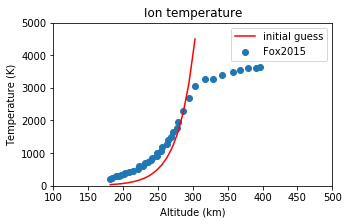

In [306]:
t_ions = ascii.read("T-ion-Fox2015.csv")
t_ions = np.asarray([sorted(list(t_ions["col1"])), sorted(list(t_ions["col2"]))]).T

t_ions_ln = t_ions[np.where(t_ions[:, 1]<310)[0], :]
t_ions_lin = t_ions[np.where(t_ions[:, 1]>=300)[0], :]

def g(z, a, b, c, d):
    return a*np.exp(b*z+c) + d

fig2 = plt.figure(figsize=(5, 3))
plt.scatter(t_ions[:, 1], t_ions[:, 0], label="Fox2015")
plt.plot(t_ions_ln[:,1], g(t_ions_ln[:,1], 0.04, 0.041, -0.8, 1), color="red", label="initial guess")  # initial guess
plt.legend()
plt.xlim(100,500)
plt.ylim(-5, 5e3)
plt.ylabel("Temperature (K)")
plt.xlabel("Altitude (km)")
plt.title("Ion temperature")
plt.show()

[  0.12269285   0.02113918   3.7515439  -16.01598621]
[   5.72503407 1404.2549793 ]


/home/emc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  


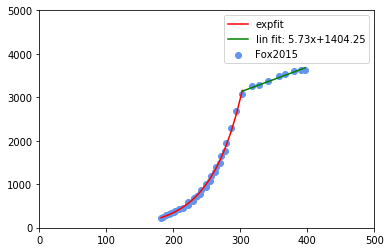

In [307]:
# Fit the ln part
popt, pcov = curve_fit(g, t_ions_ln[:, 1], t_ions_ln[:, 0], p0=(0.04, 0.041, -0.8, 1))
print(popt)

# fit the linear part
def h(x, m, b):
    return m*x + b

popt2, pcov2 = curve_fit(h, t_ions_lin[:, 1], t_ions_lin[:, 0], p0=(5, 1000))
print(popt2)

fig = plt.figure(figsize=(6,4))
plt.scatter(t_ions[:, 1], t_ions[:, 0], color="cornflowerblue", label="Fox2015")
plt.plot(t_ions_ln[:, 1], g(t_ions_ln[:, 1], *popt), color="red", label="expfit".format(*np.round(popt, 2)))
plt.plot(t_ions_lin[:, 1], h(t_ions_lin[:, 1], *popt2), color="green", label="lin fit: {}x+{}".format(*np.round(popt2, 2)))
plt.legend()
plt.ylim(-5, 5000)
plt.xlim(0, 500)
plt.show()

# Electrons

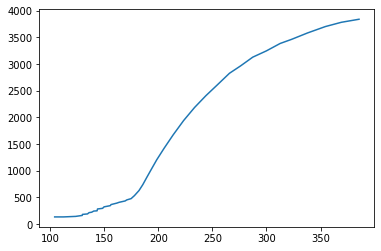

In [409]:
t_e = ascii.read("T-electrons-Fox2015.csv")
t_e = np.asarray([sorted(list(t_e["col1"])), sorted(list(t_e["col2"]))]).T

# plot just the data
plt.plot(t_e[:,1], t_e[:, 0])
plt.show()

t_e_ln = t_e[np.where(t_e[:, 1]>180)[0], :]
t_e_lin = t_e[np.where(t_e[:, 1]<=180)[0], :]

def f(x, a, b, c, d):
    return a * np.log(b * x + c) + d

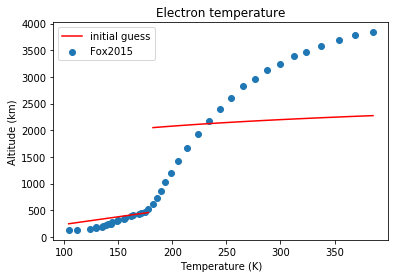

In [410]:
plt.scatter(t_e[:, 1], t_e[:, 0], label="Fox2015")
plt.plot(t_e_lin[:, 1], h(t_e_lin[:, 1], 500/175, -50), label="initial guess", color="red")
plt.plot(t_e_ln[:, 1], f(t_e_ln[:, 1], 300, 5, 1, 5), color="red")
# plt.xlim(100,4*10**3)
plt.xlabel("Temperature (K)")
plt.ylabel("Altitude (km)")
plt.title("Electron temperature")
plt.legend()
plt.show()

[   5.89653103 -567.88637905]
[ 1.67854609e+03  5.33606109e+00 -8.09824857e+02 -8.00798862e+03]


/home/emc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log
  if sys.path[0] == '':


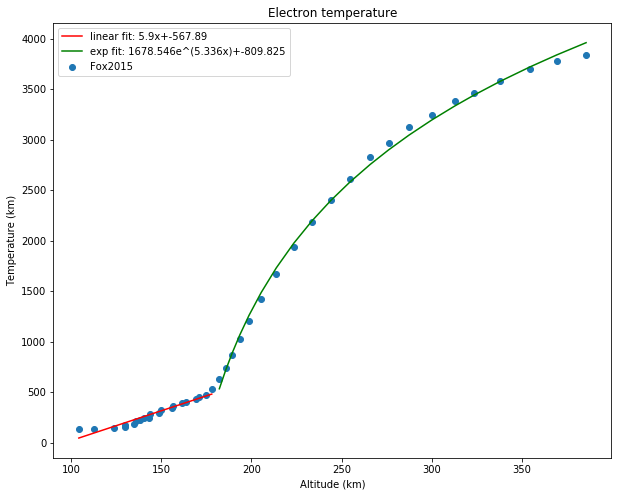

In [411]:
# Fit the linear region
popt, pcov = curve_fit(h, t_e_lin[:, 1], t_e_lin[:, 0], p0=(500/175, -50))
print(popt)

# Fit the exponential region
popt2, pcov2 = curve_fit(f, t_e_ln[:, 1], t_e_ln[:, 0], p0=(300, 5, 1, 5))
print(popt2)

# print(t_e_ln[:, 1])
# print(f(t_e_ln[:, 1], *popt2))

# Plot
fig = plt.figure(figsize=(10,8))
plt.scatter(t_e[:, 1], t_e[:, 0], label="Fox2015")
plt.plot(t_e_lin[:, 1], h(t_e_lin[:, 1], *popt), color="red", label="linear fit: {}x+{}".format(*np.round(popt, 2)))
plt.plot(t_e_ln[:, 1], f(t_e_ln[:, 1], *popt2), color="green", label="exp fit: {}e^({}x)+{}".format(*np.round(popt2, 3)))
plt.xlabel("Altitude (km)")
plt.ylabel("Temperature (km)")
plt.title("Electron temperature")
# plt.xlim(100,4*10**3)
plt.legend()
plt.show()

# Stitch it together with temperature profiles

In [420]:
def Tn(z, Tsurf, Ttropo, Texo, E=""):
    """
    Neutral temps

    z: altitude above surface in cm
    Tsurf: Surface temperature in K
    Tropo: tropopause tempearture
    Texo: exobase temperature
    E: type of experiment, used for determining if mesopause width will vary 
    """
    
    lapserate = -1.4e-5 # lapse rate in K/cm
    ztropo = 120e5  # height of the tropopause top
    
    # set the width of tropopause. It varies unless we're only varying the 
    # exobase temperature.
    if (E=="tropo") or (E=="surf"):
        ztropo_bot = (Ttropo-Tsurf)/(lapserate)
        ztropowidth = ztropo - ztropo_bot
    else:
        ztropo_bot = (Ttropo-Tsurf)/(lapserate)
        ztropowidth = ztropo - ztropo_bot

    if z >= ztropo:  # upper atmosphere
        return Texo - (Texo - Ttropo)*np.exp(-((z-ztropo)**2)/(8e10*Texo))
    elif ztropo > z >= ztropo - ztropowidth:  # tropopause
        return Ttropo
    elif ztropo-ztropowidth > z:  # lower atmosphere
        return Tsurf + lapserate*z
    
    
def Ti(z, Tsurf, Ttropo, Texo, E=""):
    """
    Ion temps
    """
    
    lapserate = -1.4e-5 # lapse rate in K/cm
    ztropo = 120e5  # height of the tropopause top
    
    # set the width of tropopause. It varies unless we're only varying the 
    # exobase temperature.
    if (E=="tropo") or (E=="surf"):
        ztropo_bot = (Ttropo-Tsurf)/(lapserate)
        ztropowidth = ztropo - ztropo_bot
    else:
        ztropo_bot = (Ttropo-Tsurf)/(lapserate)
        ztropowidth = ztropo - ztropo_bot

    if z > 300e5:
        return 5.02005087*(z/1e5)+1404.22742717
    elif 180e5 < z < 310e5:   # point where ions split off
        A =  0.12269285
        B = 0.02113918    
        C = 3.7515439
        D = -16.01598621
        return A*(np.exp(B*(z/1e5) + C)) + D
    elif ztropo <= z <= 180e5:  # upper atmosphere
        return Texo - (Texo - Ttropo)*np.exp(-((z-ztropo)**2)/(8e10*Texo))
    elif ztropo > z >= ztropo - ztropowidth:  # tropopause
        return Ttropo
    elif ztropo-ztropowidth > z:  # lower atmosphere
        return Tsurf + lapserate*z
    
def Te(z, Tsurf, Ttropo, Texo, E=""):
    """
    Electrons temps
    """
    
    lapserate = -1.4e-5 # lapse rate in K/cm
    ztropo = 120e5  # height of the tropopause top
    
    # set the width of tropopause. It varies unless we're only varying the 
    # exobase temperature.
    if (E=="tropo") or (E=="surf"):
        ztropo_bot = (Ttropo-Tsurf)/(lapserate)
        ztropowidth = ztropo - ztropo_bot
    else:
        ztropo_bot = (Ttropo-Tsurf)/(lapserate)
        ztropowidth = ztropo - ztropo_bot 
        
    if z > 182e5:
        A = 1.67854609e3
        B = 5.33606109
        C = -8.09824857e2
        D = -8.00798862e3
        return A*(np.log(B*(z/1e5) + C)) + D
    elif 100e5 < z <= 182e5:   # point where ions split off
        return 5.89653103*(z/1e5)-470
    elif ztropo <= z <= 100e5:  # upper atmosphere
        return Texo - (Texo - Ttropo)*np.exp(-((z-ztropo)**2)/(8e10*Texo))
    elif ztropo > z >= ztropo - ztropowidth:  # tropopause
        return Ttropo
    elif ztropo-ztropowidth > z:  # lower atmosphere
        return Tsurf + lapserate*z

[]

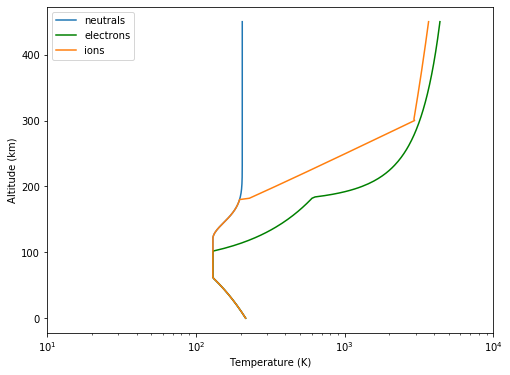

In [422]:
# neutral temperatures
altgrid = np.arange(0, 452e5, 2e5)
T_neutrals = [Tpiecewise(a, 216, 130, 205) for a in altgrid]

# ion temperatures
T_ions = [Ti(a, 216, 130, 205) for a in altgrid]

# electron temperatures
T_electrons = [Te(a, 216, 130, 205) for a in altgrid]
# print(T_electrons)

# plot
fig = plt.figure(figsize=(8,6))
plt.plot(T_neutrals, altgrid/1e5, label="neutrals")
plt.plot(T_electrons, altgrid/1e5, label="electrons", color="green")
# plt.axhline(310, color="gray")
plt.plot(T_ions, altgrid/1e5, label="ions")
plt.xlim(10, 1e4)
plt.xscale("log")
plt.xlabel("Temperature (K)")
plt.ylabel("Altitude (km)")
plt.legend()
plt.plot()